In [3]:
cd ..

/home/jovyan/Robbi/dea-intertidal


In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

### BOM tide guage data
http://www.bom.gov.au/oceanography/projects/abslmp/data/index.shtml

In [82]:
pd.read_csv('data/raw/ABSLMP_station_metadata.csv', index_col='ID CODE')

,STATE,TOWN / DISTRICT,AHD,SSBM,LATITUDE,LONGITUDE
ID CODE,,,,,,
IDO71001,Queensland,Townsville - Cape Ferguson,1.590,6.9890,-19.277333,147.058444
IDO71002,Queensland,Rockhampton - Rosslyn Bay,2.360,8.1670,-23.161028,150.790167
IDO71003,New South Wales,Port Kembla,0.872,5.0450,-34.473750,150.911861
IDO71004,Victoria,Stony Point,1.690,5.0420,-38.372139,145.224694
IDO71006,Victoria,Lorne,1.423,4.4610,-38.547194,143.988833
IDO71005,Tasmania,Burnie,1.938,6.5350,-41.050083,145.915000
IDO71007,Tasmania,Triabunna - Spring Bay,1.153,4.6530,-42.545861,147.932722
IDO71008,Victoria,Portland,0.507,3.4250,-38.343444,141.613167
IDO71009,South Australia,Adelaide - Port Stanvac,1.280,7.5781,-35.108611,138.467028


Loading data for Broome


<AxesSubplot:xlabel=' Date & UTC Time'>

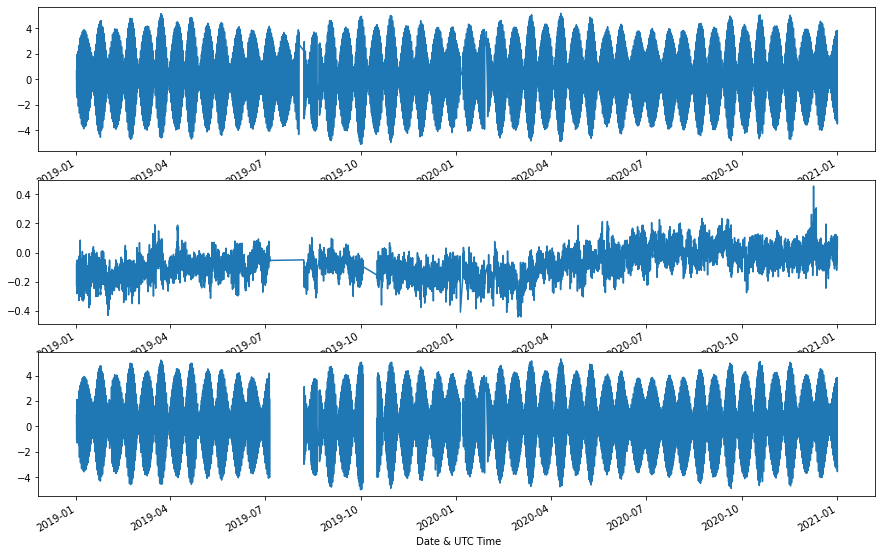

In [141]:
site = "IDO71015"

# def abslmp_correction(

from shapely.ops import nearest_points
from shapely.geometry import Point
import geopandas as gpd

data_path='data/raw/ABSLMP'
in_coords = gpd.GeoDataFrame(geometry=[Point(119.19939624, -16.58080842)], crs="EPSG:4326").to_crs(
    "EPSG:3577"
)

# Load station metadata
site_metadata_df = pd.read_csv(
    f"{data_path}/ABSLMP_station_metadata.csv", index_col="ID CODE"
)

# Convert to GeoDataFrame
sites_metadata_gdf = gpd.GeoDataFrame(
    data=site_metadata_df,
    geometry=gpd.points_from_xy(site_metadata_df.LONGITUDE, site_metadata_df.LATITUDE),
    crs="EPSG:4326",
).to_crs("EPSG:3577")

# Find nearest row
site_metadata_gdf = gpd.sjoin_nearest(in_coords, sites_metadata_gdf).iloc[0]

# Read all tide data
print(f"Loading data for {site_metadata_gdf['TOWN / DISTRICT']}")
df = pd.concat(
    [
        pd.read_csv(
            f"{data_path}/{site_metadata_gdf.index_right}_{year}.csv",
            index_col=0,
            parse_dates=True,
            na_values=-9999,
        )
        for year in range(2019, 2021)
    ]
)

# Extract water level and residuals
time = slice(None)
water_level = df["Sea Level"][time].dropna() - site_metadata_gdf.AHD
residuals = df["Adjusted Residuals"][time].dropna()
no_residual = water_level - residuals

# Plot
fig, axes = plt.subplots(3, 1, figsize=(15, 10))
water_level.plot(ax=axes[0])
residuals.plot(ax=axes[1])
no_residual.plot(ax=axes[2])

<AxesSubplot:xlabel='week'>

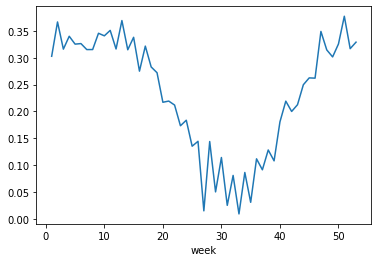

In [142]:
weekly_correction = no_residual.groupby(no_residual.index.isocalendar().week).mean()
weekly_correction.plot()

In [107]:
# df = pd.concat([pd.read_csv(f'data/raw/{site}_{year}.csv',
#                             index_col=0,
#                             parse_dates=True,
#                             na_values=-9999)
#                 for year in range(2019, 2021)])

# # Set freq
# df = df.resample("1H").interpolate(method="time")

,geometry,index_right,STATE,TOWN / DISTRICT,AHD,SSBM,LATITUDE,LONGITUDE
0,POINT (468492.386 -1666515.650),IDO71015,Northern Territory,Milner Bay - Groote Eylandt,1.21,6.8639,-13.860056,136.415583


,geometry
0,POINT (136.34000 -15.61000)


/tmp/ipykernel_4059/2190028592.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:3577

  gpd.sjoin_nearest(gpd.GeoDataFrame(geometry=[in_coords], crs="EPSG:4326"), site_metadata_gdf)
/env/lib/python3.8/site-packages/geopandas/array.py:341: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


,geometry,index_right,STATE,TOWN / DISTRICT,AHD,SSBM,LATITUDE,LONGITUDE
0,POINT (136.34000 -15.61000),IDO71014,Northern Territory,Darwin,4.105,10.479,-12.471778,130.845861


<AxesSubplot:xlabel=' Date & UTC Time'>

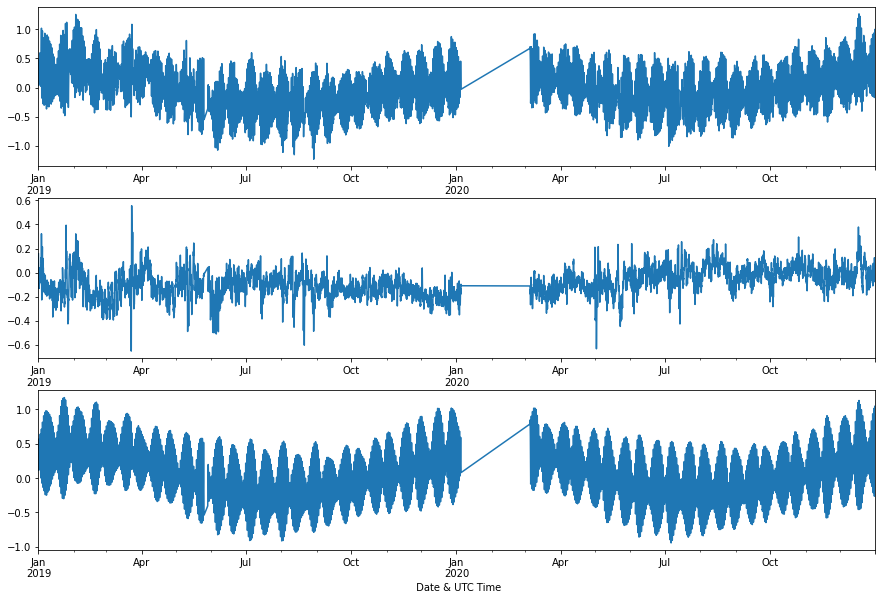

In [23]:
# Set optional time slice
time = slice(None)
# time = slice('2015-10', '2016-03')

# Extract water level and residuals
water_level = df['Sea Level'][time].dropna() - site_metadata.AHD
residuals = df['Adjusted Residuals'][time].dropna()
no_residual = water_level - residuals

# Plot
fig, axes = plt.subplots(3, 1, figsize=(15, 10))
water_level.plot(ax=axes[0])
residuals.plot(ax=axes[1])
no_residual.plot(ax=axes[2])

<AxesSubplot:xlabel='week'>

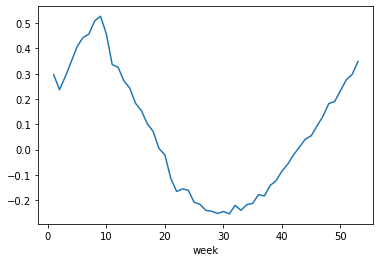

In [74]:
weekly_correction = no_residual.groupby(no_residual.index.isocalendar().week).mean()
weekly_correction.plot()
# .to_csv('data/raw/weekly_correction.csv')

In [66]:
doy_mean = no_residual.groupby(no_residual.index.day_of_year).mean()

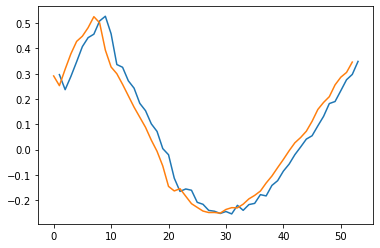

In [80]:

from scipy.signal import savgol_filter
plt.plot(weekly_correction)
plt.plot(savgol_filter(weekly_correction, 4, 2))

In [77]:
weekly_correction.

week
1     0.296377
2     0.236924
3     0.289202
4     0.347283
5     0.407102
6     0.442466
7     0.456086
8     0.508307
9     0.526962
10    0.457625
11    0.336196
12    0.325402
13    0.272003
14    0.242890
15    0.182780
16    0.153735
17    0.101976
18    0.071976
19    0.004083
20   -0.020128
21   -0.112638
22   -0.165026
23   -0.155318
24   -0.160384
25   -0.208155
26   -0.215836
27   -0.239961
28   -0.243336
29   -0.252158
30   -0.244429
31   -0.253905
32   -0.220024
33   -0.239747
34   -0.217042
35   -0.212259
36   -0.177774
37   -0.182804
38   -0.141437
39   -0.122631
40   -0.084848
41   -0.057161
42   -0.019872
43    0.010283
44    0.041673
45    0.054875
46    0.093917
47    0.131506
48    0.182042
49    0.190101
50    0.232774
51    0.276158
52    0.297125
53    0.348542
dtype: float64

<AxesSubplot:>

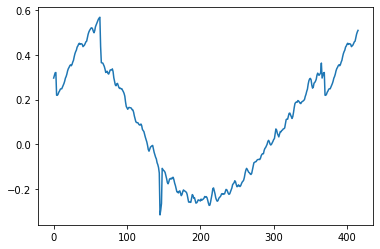

In [59]:
pd.concat([doy_mean, doy_mean.iloc[0:50]]).reset_index(drop=True).plot()

In [33]:
.rolling('2s', min_periods=1).sum()

Int64Index([  1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
            ...
            366, 366, 366, 366, 366, 366, 366, 366, 366, 366],
           dtype='int64', name=' Date & UTC Time', length=17544)

In [ ]:
no_residual.groupby(no_residual.index.isocalendar().week).mean()

In [8]:
out = no_residual.groupby(no_residual.index.day_of_year).transform(lambda x: x-x.mean())

In [9]:
out = no_residual.groupby(no_residual.index.day_of_year).transform(lambda x: x-x.mean())

<AxesSubplot:xlabel=' Date & UTC Time'>

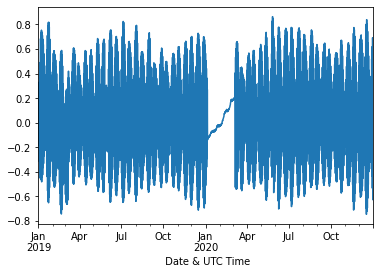

In [11]:
out.plot()

In [12]:
testing['comparison'] = out.values

NameError: name 'testing' is not defined

<AxesSubplot:xlabel='tide_m', ylabel='comparison'>

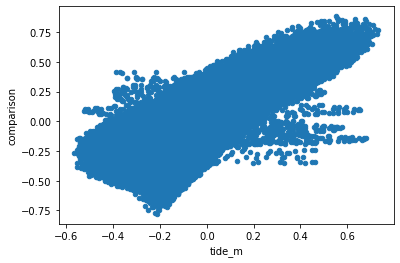

In [270]:
testing.plot.scatter(x='tide_m', y='comparison')

<AxesSubplot:xlabel='time'>

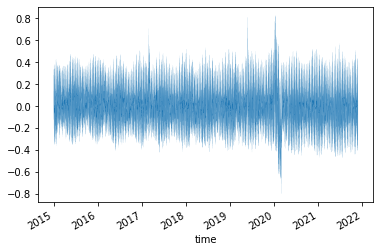

In [271]:
(testing['tide_m'] - testing['comparison']).plot(linewidth=0.05)

<AxesSubplot:xlabel='time'>

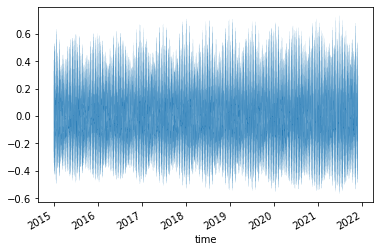

In [266]:
testing['tide_m'].plot(linewidth=0.05)

<AxesSubplot:xlabel='time'>

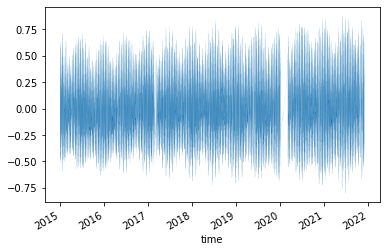

In [267]:
testing['comparison'].plot(linewidth=0.05)

In [234]:
no_residual.index.weekofyear

/tmp/ipykernel_112/3897820445.py:1: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  no_residual.index.weekofyear


Int64Index([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
            ...
            48, 48, 48, 48, 48, 48, 48, 48, 48, 48],
           dtype='int64', name=' Date & UTC Time', length=60624)

In [124]:
import statsmodels.tsa.seasonal as sm_seasonal

In [276]:
decomposition = sm_seasonal.seasonal_decompose(no_residual)

In [294]:
out = sm_seasonal.STL(no_residual, trend=181)

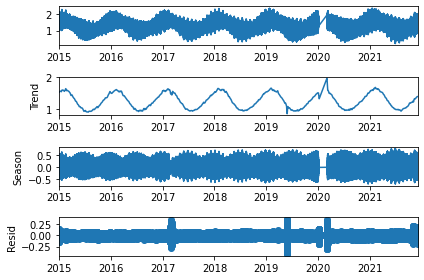

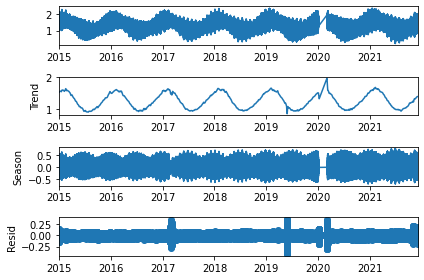

In [295]:
out.fit().plot()

<AxesSubplot:xlabel=' Date & UTC Time'>

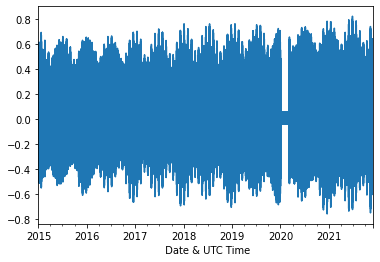

In [277]:
decomposition.resid.plot()

<AxesSubplot:xlabel=' Date & UTC Time'>

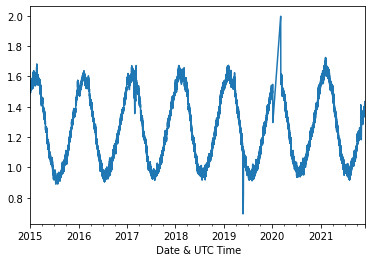

In [278]:
decomposition.trend.plot()

<AxesSubplot:xlabel=' Date & UTC Time'>

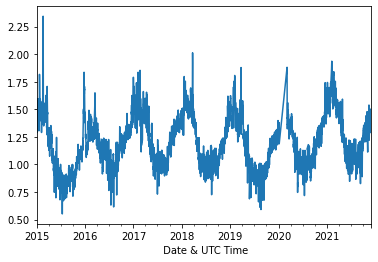

In [32]:
decomposition.trend.plot()

In [65]:
import scipy as sp
import scipy.fftpack

<AxesSubplot:xlabel=' Date & UTC Time'>

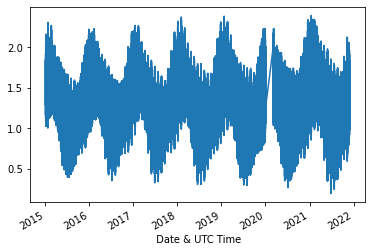

In [119]:
no_residual.plot()

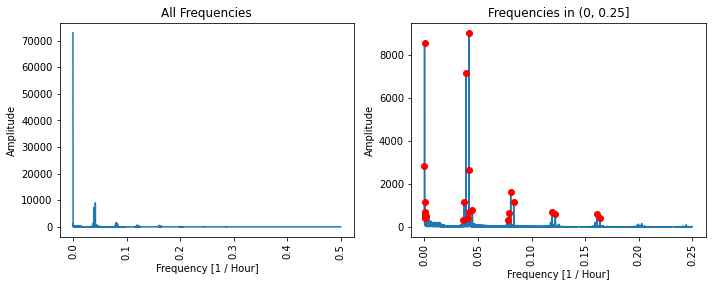

In [226]:
time = water_level.index
residuals = water_level.values

from scipy import fft
import scipy.signal
fft_output = fft.fft(residuals)
power = np.abs(fft_output)
freq = fft.fftfreq(len(residuals))

mask = freq >= 0
freq = freq[mask]
power = power[mask]

plt.figure( figsize=(10, 4) )

ax1 = plt.subplot( 1, 2, 1 )
ax1.plot(freq, power, label='signal')
ax1.set_title('All Frequencies')
ax1.set_ylabel( 'Amplitude' )
ax1.set_xlabel( 'Frequency [1 / Hour]' )
plt.xticks(rotation=90)

ax2 = plt.subplot( 1, 2, 2 )
mask = (freq > 0) & (freq <= 0.25)
ax2.plot(freq[mask], power[mask])
ax2.set_title('Frequencies in (0, 0.25]')
ax2.set_ylabel( 'Amplitude' )
ax2.set_xlabel( 'Frequency [1 / Hour]' )

peaks = scipy.signal.find_peaks(power[freq >=0], prominence=10**2.5)[0]
peak_freq =  freq[peaks]
peak_power = power[peaks]
plt.plot(peak_freq, peak_power, 'ro')

plt.tight_layout()
plt.xticks(rotation=90);


In [227]:
output = pd.DataFrame()
output['index'] = peaks
output['freq (1/hour)'] = peak_freq
output['amplitude'] = peak_power
output['period (days)'] = 1 / peak_freq / 24
output['fft'] = fft_output[peaks]
output = output.sort_values('amplitude', ascending=False)

output

,index,freq (1/hour),amplitude,period (days),fft
16,2533,0.041782,9026.092389,0.997236,-4313.399766+7928.740523j
1,7,0.000115,8534.964991,360.857143,5982.433650-6087.373410j
12,2348,0.038731,7171.207274,1.075809,4259.725611-5768.964508j
0,2,0.000033,2850.418580,1263.000000,403.114614+2821.769780j
14,2519,0.041551,2622.828270,1.002779,-2248.537335+1350.299221j
20,4881,0.080513,1606.593625,0.517517,1261.107562+995.364654j
11,2256,0.037213,1172.655371,1.119681,1069.109627-481.793758j
21,5052,0.083333,1153.644878,0.500000,-382.297963-1088.459817j
2,14,0.000231,1136.091582,180.428571,-929.2393620-653.6193770j
17,2718,0.044834,761.602028,0.929360,355.6690530+673.4516870j


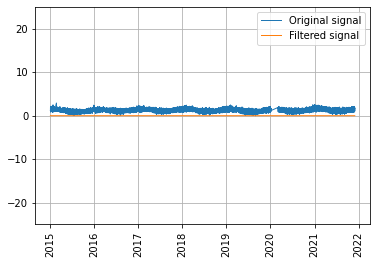

In [220]:
filtered_fft_output = np.array([f if i == 1626 else 0 for i, f in enumerate(fft_output)])
filtered_sig = fft.ifft(filtered_fft_output)

N = 24 * 8000
plt.plot(time[:N], water_level[:N], linewidth=1, label='Original signal')
plt.plot(time[:N], filtered_sig[:N].real, linewidth=1, label='Filtered signal')
plt.legend(loc='upper right')
ax2.set_title('First 5 Days')
plt.grid()
plt.ylim((-25, 25))
plt.xticks(rotation=90)

print()

In [181]:
temp = no_residual
# temp = water_level

temp_fft = sp.fftpack.fft(temp.values)

In [182]:
temp_psd = np.abs(temp_fft) ** 2

In [186]:
fftfreq = sp.fftpack.fftfreq(len(temp_psd), 1. / (365.25*24))

In [187]:
i = fftfreq > 0

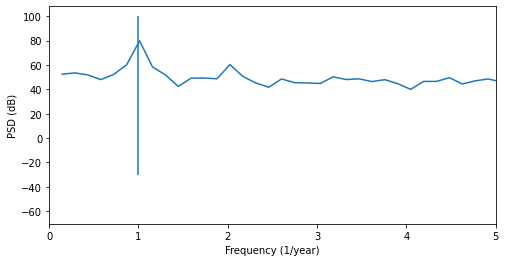

In [189]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(fftfreq[i], 10 * np.log10(temp_psd[i]))
ax.set_xlim(0, 5)
ax.set_xlabel('Frequency (1/year)')
ax.set_ylabel('PSD (dB)')
ax.vlines(1, ymin=-30, ymax=100)

In [190]:
temp_fft_bis = temp_fft.copy()
temp_fft_bis[np.abs(fftfreq) > 1.1] = 0

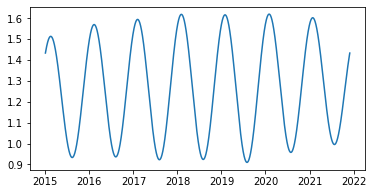

In [191]:
temp_slow = np.real(sp.fftpack.ifft(temp_fft_bis))
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
# temp.plot(ax=ax, lw=.5)
ax.plot(temp.index, temp_slow, '-')


In [180]:
temp.plot(ax=ax, lw=.5)

<AxesSubplot:xlabel=' Date & UTC Time'>

In [168]:
len(temp_slow)

60624

In [111]:
(testing['tide_m'] - (df['Sea Level'] - df['Adjusted Residuals']).values).plot(figsize=(10, 5), linewidth=0.2)

NameError: name 'testing' is not defined

Plotting residuals:

(-0.6, 0.6)

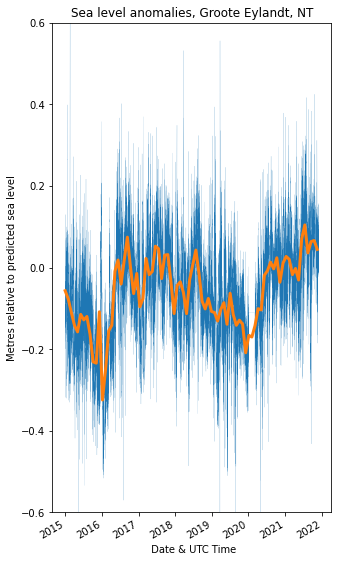

In [93]:
residuals.plot(figsize=(5, 10), linewidth=0.1)
residuals.resample(rule='31D').mean().plot(ax=plt.gca(), linewidth=3)
plt.title('Sea level anomalies, Groote Eylandt, NT')
plt.ylabel('Metres relative to predicted sea level')
plt.ylim(-0.6, 0.6)

In [242]:
import otps
import pytz

def otps_tides(lats, lons, times, timezone=None):
    """
    Model tide heights for one or more locations and times using the
    OTPS TPXO8 tidal model.
    Parameters:
    -----------
    lats, lons : numeric or list of numeric values
        One or more latitudes and longitude coordinates used to define
        the location at which to model tides.
    times : datetime.datetime or list of datetime.datetimes
        One or more `datatime.datetime` objects providing the times at
        which to model tides. By default these are assumed to be in UTC
        time; if this is not the case, use `timezone` below.
    timezone : string, optional
        If provided `datatime.datetime`s are not in UTC times, use this
        parameter to declare a timezone. E.g. to model tides for times
        expressed in local time at Darwin, Australia, provide
        `timezone='Australia/Darwin'`. Defaults to `None`, which assumes
        provided times are UTC. This is used to convert all times to UTC
        using the `pytz` module. For a full list of timezones, run:
        `import pytz; pytz.all_timezones`.
    Returns:
    --------
    tidepoints_df : pandas.DataFrame
        An `pandas.DataFrame` with a "time" index, "lat" and "lon"
        columns, and a "tide_m" column giving tide heights at each
        point location.
    """

    # Convert to list if provided as individual values
    if not isinstance(lats, list):
        lats = [lats]
    if not isinstance(lons, list):
        lons = [lons]
    if not isinstance(times, list):
        times = [times]

    # If a timezone is provided, localise the input times then
    # standardise to UTC times
    if timezone:
        times = [
            pytz.timezone(timezone).localize(time).astimezone(pytz.utc)
            for time in times
        ]

    # Create list of lat/lon/time scenarios to model tides
    observed_timepoints = [
        otps.TimePoint(lon, lat, time)
        for time in times
        for lon, lat in zip(lons, lats)
    ]

    # Model tides for each lat/lon/time
    observed_predictedtides = otps.predict_tide(observed_timepoints)

    # Output results into pandas.DataFrame
    tidepoints_df = pd.DataFrame(
        [(i.timepoint.timestamp, i.timepoint.lon, i.timepoint.lat, i.tide_m)
         for i in observed_predictedtides],
        columns=['time', 'lon', 'lat', 'tide_m'])

    return tidepoints_df.set_index('time')

In [243]:
lat, lon = -13.860066, 136.415240

testing = otps_tides(lat, lon, df.index.to_pydatetime().tolist())

<AxesSubplot:xlabel='time'>

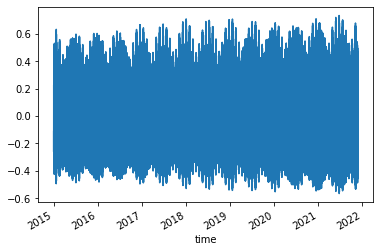

### Pytides

In [69]:
from pytides.tide import Tide

demeaned = water_level - water_level.mean()
tide = Tide.decompose(demeaned, water_level.index)
(demeaned - tide.at(water_level.index)).plot(figsize=(13, 10))